In [2]:
import os
import gc
import time
import math
import random
import glob

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
from typing import Tuple, Optional


In [4]:
config = {
    'BASE_DIR': r'C:\Users\User\Diploma_dataset\merged_dataset',
    'IMG_SIZE': 256,
    'EPOCHS': 30,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'NUM_CLASSES': 1,
    'USE_AMP': True,
    'BATCH_SIZE': 6,
    'LEARNING_RATE': 2e-4,
    'TRAIN_SUBSET': 300,
    'VAL_SUBSET': 75,
    'VALIDATION_FREQ': 3,
    'MEMORY_CLEANUP_FREQ': 5,
    'WEIGHT_DECAY': 1e-5,
}

In [14]:
def fast_memory_clear():
    """Ultra-fast memory clearing"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


# Convolutional block

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_residual=True):
        super().__init__()
        self.use_residual = use_residual and (in_channels == out_channels)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        
        self.se = SEBlock(out_channels)
        
    def forward(self, x):
        identity = x if self.use_residual else None
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
    
        out = self.se(out)
        
        if self.use_residual:
            out += identity
        
        return self.relu(out)

# Transformer block

In [ ]:
class TransformerBottleneck(nn.Module):
    def __init__(self, in_channels=512, patch_size=8, embed_dim=512, num_heads=8, num_layers=2):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.feature_size = 16
        self.patch_dim = self.feature_size // patch_size
        self.num_patches = self.patch_dim ** 2
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, embed_dim, self.num_patches))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*2,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.up_proj = nn.ConvTranspose2d(embed_dim, in_channels, kernel_size=patch_size, stride=patch_size)
        self.channel_adjust = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        patches = self.patch_embed(x)
        patches_flat = patches.flatten(2)
        if patches_flat.size(2) == self.pos_embed.size(2):
            patches_flat = patches_flat + self.pos_embed
        else:
            pos_embed_resized = F.interpolate(
                self.pos_embed.unsqueeze(0), 
                size=patches_flat.size(2), 
                mode='linear'
            ).squeeze(0)
            patches_flat = patches_flat + pos_embed_resized
        patches_flat = patches_flat.permute(2, 0, 1)
        transformed = self.transformer(patches_flat)
        transformed = transformed.permute(1, 2, 0)
        patch_h = patch_w = int(math.sqrt(transformed.size(2)))
        transformed = transformed.view(B, self.embed_dim, patch_h, patch_w)
        upsampled = self.up_proj(transformed)
        if upsampled.shape != x.shape:
            upsampled = F.interpolate(upsampled, size=(H, W), mode='bilinear', align_corners=False)
        output = self.channel_adjust(upsampled)
        return output + x


# Squeeze and Excitation block

In [22]:
class SEBlock(nn.Module):
   
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Spatial attention module

In [28]:
class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(attention))
        return x * attention


# Atrous Spatial Pyramid Pooling

In [26]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, 1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels//4, 3, padding=6, dilation=6, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels//4, 3, padding=12, dilation=12, bias=False)
        self.conv4 = nn.Conv2d(in_channels, out_channels//4, 3, padding=18, dilation=18, bias=False)
        
        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels//4)
        self.bn4 = nn.BatchNorm2d(out_channels//4)
        
        self.relu = nn.ReLU(inplace=True)
        
 
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.global_conv = nn.Conv2d(in_channels, out_channels//4, 1, bias=False)
        self.global_bn = nn.BatchNorm2d(out_channels//4)
        
    def forward(self, x):
        size = x.shape[-2:]
        
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.relu(self.bn2(self.conv2(x)))
        x3 = self.relu(self.bn3(self.conv3(x)))
        x4 = self.relu(self.bn4(self.conv4(x)))
        
        x5 = self.global_pool(x)
        x5 = self.relu(self.global_bn(self.global_conv(x5)))
        x5 = F.interpolate(x5, size=size, mode='bilinear', align_corners=False)
        
   
        return torch.cat([x1, x2, x3, x4, x5], dim=1)


# TransUnet

In [ ]:
class TransUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        

        channels = [32, 64, 128, 256, 512]  
        
    
        self.enc1 = ConvBlock(in_channels, channels[0], use_residual=False)
        self.enc2 = ConvBlock(channels[0], channels[1])
        self.enc3 = ConvBlock(channels[1], channels[2])
        self.enc4 = ConvBlock(channels[2], channels[3])
        
        
        self.bottleneck_pre = ConvBlock(channels[3], channels[4])
        self.aspp = ASPP(channels[4], channels[4])
        
     
        self.bottleneck_post = nn.Sequential(
            nn.Conv2d(channels[4]*2 + channels[4]//4, channels[4], 1, bias=False), 
            nn.BatchNorm2d(channels[4]),
            nn.ReLU(inplace=True),
            ConvBlock(channels[4], channels[4])
        )
        
 
        self.up4 = nn.ConvTranspose2d(channels[4], channels[3], 2, stride=2)
        self.att4 = SpatialAttention()
        self.dec4 =ConvBlock(channels[3]*2, channels[3])
        
        self.up3 = nn.ConvTranspose2d(channels[3], channels[2], 2, stride=2)
        self.att3 = SpatialAttention()
        self.dec3 = ConvBlock(channels[2]*2, channels[2])
        
        self.up2 = nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
        self.att2 = SpatialAttention()
        self.dec2 = ConvBlock(channels[1]*2, channels[1])
        
        self.up1 = nn.ConvTranspose2d(channels[1], channels[0], 2, stride=2)
        self.att1 = SpatialAttention()
        self.dec1 = ConvBlock(channels[0]*2, channels[0])
        

        self.final = nn.Conv2d(channels[0], out_channels, 1)
        

        self.aux_out4 = nn.Conv2d(channels[3], out_channels, 1)
        self.aux_out3 = nn.Conv2d(channels[2], out_channels, 1)
        self.aux_out2 = nn.Conv2d(channels[1], out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
        
        self._initialize_weights()

    def _initialize_weights(self):
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_aux=False):
        feat1 = self.enc1(x)
        x1 = self.pool(feat1)
        
        feat2 = self.enc2(x1)
        x2 = self.pool(feat2)
        
        feat3 = self.enc3(x2)
        x3 = self.pool(feat3)
        
        feat4 = self.enc4(x3)
        x4 = self.pool(feat4)
        
        x = self.bottleneck_pre(x4)
        aspp_feat = self.aspp(x)
        x = torch.cat([x, aspp_feat], dim=1)
        x = self.bottleneck_post(x)
        
        x = self.up4(x)
        feat4_att = self.att4(feat4)
        x = torch.cat([x, feat4_att], dim=1)
        x = self.dec4(x)
        aux4 = self.aux_out4(x) if return_aux else None

        
        x = self.up3(x)            
        feat3_att = self.att3(feat3)
        x = torch.cat([x, feat3_att], dim=1)  
        x = self.dec3(x)            
        aux3 = self.aux_out3(x) if return_aux else None
        
        x = self.up2(x)            
        feat2_att = self.att2(feat2)
        x = torch.cat([x, feat2_att], dim=1)  
        x = self.dec2(x)      
        aux2 = self.aux_out2(x) if return_aux else None
        
        x = self.up1(x)           
        feat1_att = self.att1(feat1)
        x = torch.cat([x, feat1_att], dim=1) 
        x = self.dec1(x)           
        
    
        main_out = self.final(x)    
        
        if return_aux:
            aux4 = F.interpolate(aux4, size=(256, 256), mode='bilinear', align_corners=False)
            aux3 = F.interpolate(aux3, size=(256, 256), mode='bilinear', align_corners=False)
            aux2 = F.interpolate(aux2, size=(256, 256), mode='bilinear', align_corners=False)
            return main_out, [aux4, aux3, aux2]
        
        return main_out


In [31]:
class SpeedDataset(Dataset):
    def __init__(self, base_dir, split='train'):
        self.image_dir = os.path.join(base_dir, split, 'images')
        self.mask_dir = os.path.join(base_dir, split, 'masks')
        self.split = split
        
        self.image_files = sorted([f for f in os.listdir(self.image_dir)
                                   if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir)
                                  if f.endswith(('.png', '.jpg', '.jpeg'))])
        
     
        self.pairs = [(f, f) for f in self.image_files if f in self.mask_files]
        
    
        if split == 'train':
            self.pairs = self.pairs[:config['TRAIN_SUBSET']]
        else:
            self.pairs = self.pairs[:config['VAL_SUBSET']]
            
        print(f"Using {len(self.pairs)} samples for {split}")
        
      
        if split == 'train':
            self.transform = transforms.Compose([
                transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE']), antialias=True),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE']), antialias=True),
                transforms.ToTensor(),
            ])
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]
        
        try:
           
            image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
            mask = Image.open(os.path.join(self.mask_dir, mask_name)).convert('L')
            
           
            seed = torch.randint(0, 2**32, (1,)).item()
            
          
            torch.manual_seed(seed)
            image = self.transform(image)
            
           
            torch.manual_seed(seed)
            mask_transform = transforms.Compose([
                transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE']), antialias=True),
                transforms.ToTensor(),
            ])
            mask = mask_transform(mask)
            
           
            image = (image - 0.5) * 2
            
            return image, mask
            
        except Exception as e:
           
            return torch.zeros(3, config['IMG_SIZE'], config['IMG_SIZE']), \
                   torch.zeros(1, config['IMG_SIZE'], config['IMG_SIZE'])


# Metrices

In [34]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5, weight_aux=0.3):
        super().__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.weight_aux = weight_aux
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, main_out, aux_outs, target):
       
        bce_loss = self.bce(main_out, target)
        dice_loss = self.dice_loss(main_out, target)
        main_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss
        
       
        aux_loss = 0
        if aux_outs is not None:
            for aux_out in aux_outs:
                aux_bce = self.bce(aux_out, target)
                aux_dice = self.dice_loss(aux_out, target)
                aux_loss += self.weight_bce * aux_bce + self.weight_dice * aux_dice
            aux_loss /= len(aux_outs)
        
        total_loss = main_loss + self.weight_aux * aux_loss
        return total_loss, main_loss, aux_loss


In [36]:
def calculate_metrics(preds, targets, threshold=0.5):
 
    preds_binary = (torch.sigmoid(preds) > threshold).float()
    targets_binary = (targets > threshold).float()
    
    
    preds_flat = preds_binary.view(preds_binary.shape[0], -1)
    targets_flat = targets_binary.view(targets_binary.shape[0], -1)
    
   
    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)
    
    
    dice = (2.0 * intersection + 1e-6) / (union + 1e-6)
    
    iou = (intersection + 1e-6) / (union - intersection + 1e-6)
    

    correct = (preds_flat == targets_flat).sum(dim=1)
    total = targets_flat.shape[1]
    accuracy = correct.float() / total
    
    return dice.mean().item(), iou.mean().item(), accuracy.mean().item()

In [38]:
def plot_training_history(train_losses, train_dices, val_losses, val_dices):
    plt.figure(figsize=(12, 5))
    
    
    if len(val_losses) > 0:
       
        val_freq = len(train_losses) // max(1, len(val_losses))
        val_x = [i * val_freq + (val_freq - 1) for i in range(len(val_losses))]
       
        val_x = [min(x, len(train_losses)-1) for x in val_x]
    else:
        val_x = []
    
 
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    if len(val_losses) > 0:
        plt.plot(val_x, val_losses, 'o-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
 
    plt.subplot(1, 2, 2)
    plt.plot(train_dices, label='Train Dice')
    if len(val_dices) > 0:
        plt.plot(val_x, val_dices, 'o-', label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Training and Validation Dice Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Training

In [40]:
def lightning_fast_training():
    print("Starting training")
    

    fast_memory_clear()
    
    train_dataset = SpeedDataset(config['BASE_DIR'], 'train')
    val_dataset = SpeedDataset(config['BASE_DIR'], 'val')
    

    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['BATCH_SIZE'],
        shuffle=True, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['BATCH_SIZE'], 
        shuffle=False, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=False
    )
    

    model = TransUNet(in_channels=3, out_channels=1)
    model = model.to(config['DEVICE'])
    

    total_params = sum(p.numel() for p in model.parameters())
    print(f" Enhanced model parameters: {total_params:,}")
    
  
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=config['LEARNING_RATE'], 
        weight_decay=config['WEIGHT_DECAY']
    )
    
 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    loss_fn = CombinedLoss()
    scaler = GradScaler() if config['USE_AMP'] else None
    
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    

    best_dice = 0
    train_start_time = time.time()
    

    train_losses_history = []
    train_dices_history = []
    val_losses_history = []
    val_dices_history = []
    
 
    for epoch in range(config['EPOCHS']):
        model.train()
        
        epoch_loss = 0
        epoch_dice = 0
        epoch_iou = 0
        epoch_acc = 0
        batch_count = 0
        
        epoch_start_time = time.time()
        
  
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['EPOCHS']}")
        
        for batch_idx, (images, masks) in enumerate(pbar):
           
            images = images.to(config['DEVICE'], non_blocking=True)
            masks = masks.to(config['DEVICE'], non_blocking=True)
            
            
            if config['USE_AMP']:
                with autocast():
                    main_out, aux_outs = model(images, return_aux=True)
                    loss, main_loss, aux_loss = loss_fn(main_out, aux_outs, masks)
            else:
                main_out, aux_outs = model(images, return_aux=True)
                loss, main_loss, aux_loss = loss_fn(main_out, aux_outs, masks)
            
         
            optimizer.zero_grad()
            if config['USE_AMP']:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            
            
            with torch.no_grad():
                dice, iou, acc = calculate_metrics(main_out, masks)
            
       
            epoch_loss += loss.item()
            epoch_dice += dice
            epoch_iou += iou
            epoch_acc += acc
            batch_count += 1
            
          
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice:.4f}',
                'IoU': f'{iou:.4f}',
                'Acc': f'{acc:.4f}'
            })
            
          
            if batch_idx % config['MEMORY_CLEANUP_FREQ'] == 0:
                fast_memory_clear()
        
    
        avg_loss = epoch_loss / batch_count
        avg_dice = epoch_dice / batch_count
        avg_iou = epoch_iou / batch_count
        avg_acc = epoch_acc / batch_count
        
        train_losses_history.append(avg_loss)
        train_dices_history.append(avg_dice)
        
        epoch_time = time.time() - epoch_start_time
        
        print(f"Epoch {epoch+1} ({epoch_time:.1f}s):")
        print(f"   Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Acc: {avg_acc:.4f}")
        
      
        if (epoch + 1) % config['VALIDATION_FREQ'] == 0:
            model.eval()
            val_loss = 0
            val_dice = 0
            val_iou = 0
            val_acc = 0
            val_count = 0
            
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(config['DEVICE'], non_blocking=True)
                    masks = masks.to(config['DEVICE'], non_blocking=True)
                    
                    
                    if config['USE_AMP']:
                        with autocast():
                            outputs = model(images, return_aux=False)
                            loss, _, _ = loss_fn(outputs, None, masks)
                    else:
                        outputs = model(images, return_aux=False)
                        loss, _, _ = loss_fn(outputs, None, masks)
                    
                    dice, iou, acc = calculate_metrics(outputs, masks)
                    
                    val_loss += loss.item()
                    val_dice += dice
                    val_iou += iou
                    val_acc += acc
                    val_count += 1
            
        
            val_loss /= val_count
            val_dice /= val_count
            val_iou /= val_count
            val_acc /= val_count
            
            val_losses_history.append(val_loss)
            val_dices_history.append(val_dice)
            
            print(f"validation:")
            print(f"   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Acc: {val_acc:.4f}")
            
            
            scheduler.step(val_dice)
            
           
            if val_dice > best_dice:
                best_dice = val_dice
                torch.save(model.state_dict(), 'best_enhanced_model.pth')
                print(f"Best model saved! Dice: {best_dice:.4f}")
        
        fast_memory_clear()
    

    total_time = time.time() - train_start_time
    print(f"\ntraining completed in {total_time:.1f}s ({total_time/60:.1f} minutes)")
    print(f"Best validation Dice: {best_dice:.4f}")
    
   
    plot_training_history(train_losses_history, train_dices_history, val_losses_history, val_dices_history)
    
    return model

⚡ ULTRA-FAST TRANSUNET TRAINING ⚡
🔧 PyTorch: 2.5.1+cu118
💻 Device: cuda
🎮 GPU: NVIDIA GeForce RTX 3050 Laptop GPU
💾 GPU Memory: 4.3 GB
🚀 Starting ENHANCED LIGHTNING FAST training...
Using 300 samples for train
Using 75 samples for val
📊 Enhanced model parameters: 15,064,492
🔢 Training batches: 50
🔢 Validation batches: 13


C:\Users\User\AppData\Local\Temp\ipykernel_10224\2780402598.py:485: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if config['USE_AMP'] else None


Epoch 1/30:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_10224\2780402598.py:523: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📈 Epoch 1 (16.5s):
   Loss: 0.7418 | Dice: 0.2869 | IoU: 0.1821 | Acc: 0.8982


Epoch 2/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 2 (16.6s):
   Loss: 0.5402 | Dice: 0.4021 | IoU: 0.2804 | Acc: 0.9396


Epoch 3/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 3 (17.1s):
   Loss: 0.4423 | Dice: 0.5230 | IoU: 0.3930 | Acc: 0.9610


C:\Users\User\AppData\Local\Temp\ipykernel_10224\2780402598.py:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 Validation:
   Loss: 0.3245 | Dice: 0.5341 | IoU: 0.3995 | Acc: 0.9647
💾 Best model saved! Dice: 0.5341


Epoch 4/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 4 (17.4s):
   Loss: 0.3813 | Dice: 0.5958 | IoU: 0.4625 | Acc: 0.9687


Epoch 5/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 5 (17.4s):
   Loss: 0.3482 | Dice: 0.6247 | IoU: 0.4936 | Acc: 0.9712


Epoch 6/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 6 (17.0s):
   Loss: 0.3186 | Dice: 0.6566 | IoU: 0.5259 | Acc: 0.9744
🔍 Validation:
   Loss: 0.2628 | Dice: 0.6258 | IoU: 0.4967 | Acc: 0.9705
💾 Best model saved! Dice: 0.6258


Epoch 7/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 7 (17.4s):
   Loss: 0.2890 | Dice: 0.6904 | IoU: 0.5615 | Acc: 0.9763


Epoch 8/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 8 (17.2s):
   Loss: 0.2373 | Dice: 0.7501 | IoU: 0.6311 | Acc: 0.9810


Epoch 9/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 9 (16.9s):
   Loss: 0.2251 | Dice: 0.7613 | IoU: 0.6504 | Acc: 0.9821
🔍 Validation:
   Loss: 0.1962 | Dice: 0.7215 | IoU: 0.6045 | Acc: 0.9798
💾 Best model saved! Dice: 0.7215


Epoch 10/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 10 (17.4s):
   Loss: 0.2293 | Dice: 0.7539 | IoU: 0.6377 | Acc: 0.9812


Epoch 11/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 11 (17.3s):
   Loss: 0.1926 | Dice: 0.7982 | IoU: 0.6900 | Acc: 0.9844


Epoch 12/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 12 (16.8s):
   Loss: 0.1709 | Dice: 0.8198 | IoU: 0.7167 | Acc: 0.9868
🔍 Validation:
   Loss: 0.2024 | Dice: 0.6955 | IoU: 0.5849 | Acc: 0.9799


Epoch 13/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 13 (17.4s):
   Loss: 0.1452 | Dice: 0.8481 | IoU: 0.7549 | Acc: 0.9889


Epoch 14/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 14 (17.1s):
   Loss: 0.1532 | Dice: 0.8338 | IoU: 0.7413 | Acc: 0.9886


Epoch 15/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 15 (17.3s):
   Loss: 0.1302 | Dice: 0.8640 | IoU: 0.7744 | Acc: 0.9900
🔍 Validation:
   Loss: 0.1648 | Dice: 0.7705 | IoU: 0.6612 | Acc: 0.9823
💾 Best model saved! Dice: 0.7705


Epoch 16/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 16 (16.9s):
   Loss: 0.1224 | Dice: 0.8712 | IoU: 0.7871 | Acc: 0.9907


Epoch 17/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 17 (17.9s):
   Loss: 0.1237 | Dice: 0.8704 | IoU: 0.7869 | Acc: 0.9903


Epoch 18/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 18 (17.3s):
   Loss: 0.1112 | Dice: 0.8821 | IoU: 0.8019 | Acc: 0.9914
🔍 Validation:
   Loss: 0.1597 | Dice: 0.7693 | IoU: 0.6639 | Acc: 0.9840


Epoch 19/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 19 (16.6s):
   Loss: 0.1065 | Dice: 0.8866 | IoU: 0.8122 | Acc: 0.9920


Epoch 20/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 20 (17.1s):
   Loss: 0.0906 | Dice: 0.9060 | IoU: 0.8390 | Acc: 0.9930


Epoch 21/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 21 (16.9s):
   Loss: 0.0897 | Dice: 0.9064 | IoU: 0.8379 | Acc: 0.9932
🔍 Validation:
   Loss: 0.1482 | Dice: 0.7917 | IoU: 0.6915 | Acc: 0.9844
💾 Best model saved! Dice: 0.7917


Epoch 22/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 22 (17.5s):
   Loss: 0.0757 | Dice: 0.9216 | IoU: 0.8627 | Acc: 0.9944


Epoch 23/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 23 (17.3s):
   Loss: 0.0690 | Dice: 0.9274 | IoU: 0.8739 | Acc: 0.9951


Epoch 24/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 24 (16.6s):
   Loss: 0.0671 | Dice: 0.9303 | IoU: 0.8758 | Acc: 0.9952
🔍 Validation:
   Loss: 0.1440 | Dice: 0.7989 | IoU: 0.7034 | Acc: 0.9857
💾 Best model saved! Dice: 0.7989


Epoch 25/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 25 (17.7s):
   Loss: 0.0657 | Dice: 0.9321 | IoU: 0.8784 | Acc: 0.9952


Epoch 26/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 26 (17.3s):
   Loss: 0.0544 | Dice: 0.9447 | IoU: 0.8994 | Acc: 0.9961


Epoch 27/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 27 (17.6s):
   Loss: 0.0494 | Dice: 0.9506 | IoU: 0.9097 | Acc: 0.9965
🔍 Validation:
   Loss: 0.1342 | Dice: 0.8198 | IoU: 0.7232 | Acc: 0.9856
💾 Best model saved! Dice: 0.8198


Epoch 28/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 28 (16.8s):
   Loss: 0.0494 | Dice: 0.9492 | IoU: 0.9076 | Acc: 0.9965


Epoch 29/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 29 (17.2s):
   Loss: 0.0448 | Dice: 0.9550 | IoU: 0.9177 | Acc: 0.9969


Epoch 30/30:   0%|          | 0/50 [00:00<?, ?it/s]

📈 Epoch 30 (17.0s):
   Loss: 0.0418 | Dice: 0.9584 | IoU: 0.9239 | Acc: 0.9971
🔍 Validation:
   Loss: 0.1244 | Dice: 0.8372 | IoU: 0.7453 | Acc: 0.9866
💾 Best model saved! Dice: 0.8372

🎉 Enhanced training completed in 536.6s (8.9 minutes)
🏆 Best validation Dice: 0.8372


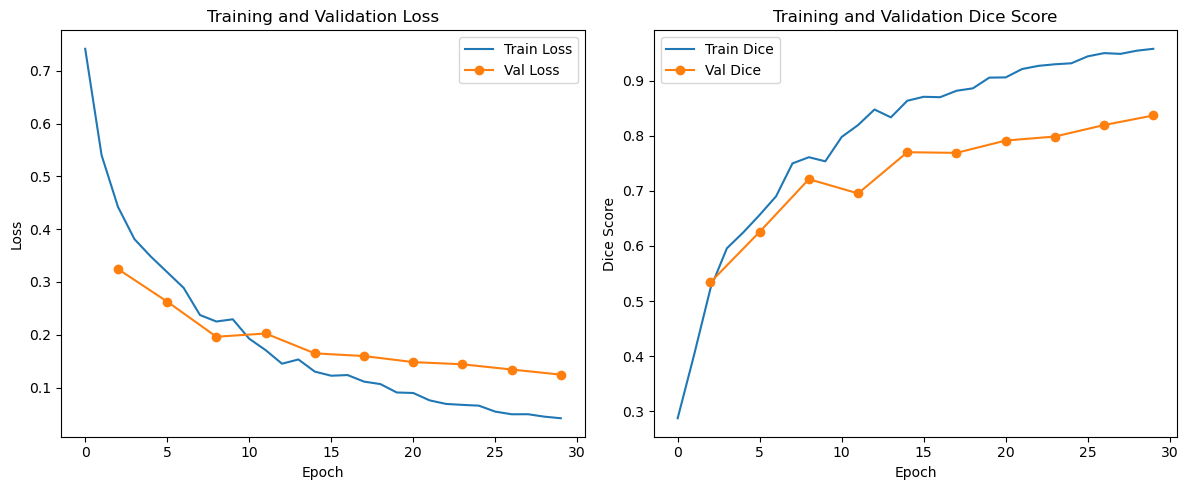

Using 75 samples for val
💾 Final model saved as 'final_fast_model.pth'


In [5]:
def main():
    print("ULTRA-FAST TRANSUNET TRAINING ")
    print(f"PyTorch: {torch.__version__}")
    print(f"Device: {config['DEVICE']}")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
 
    if not os.path.exists(config['BASE_DIR']):
        print(f"Dataset not found: {config['BASE_DIR']}")
        return
    
    try:
       
        model = lightning_fast_training()
        
 
        val_dataset = SpeedDataset(config['BASE_DIR'], 'val')
        test_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False)
        
        
       
        torch.save(model.state_dict(), 'final_fast_model.pth')
        print("Final model saved as 'final_fast_model.pth'")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
 

if __name__ == "__main__":
    main()

C:\Users\User\AppData\Local\Temp\ipykernel_10224\2052461272.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_enhanced_model.pth'))


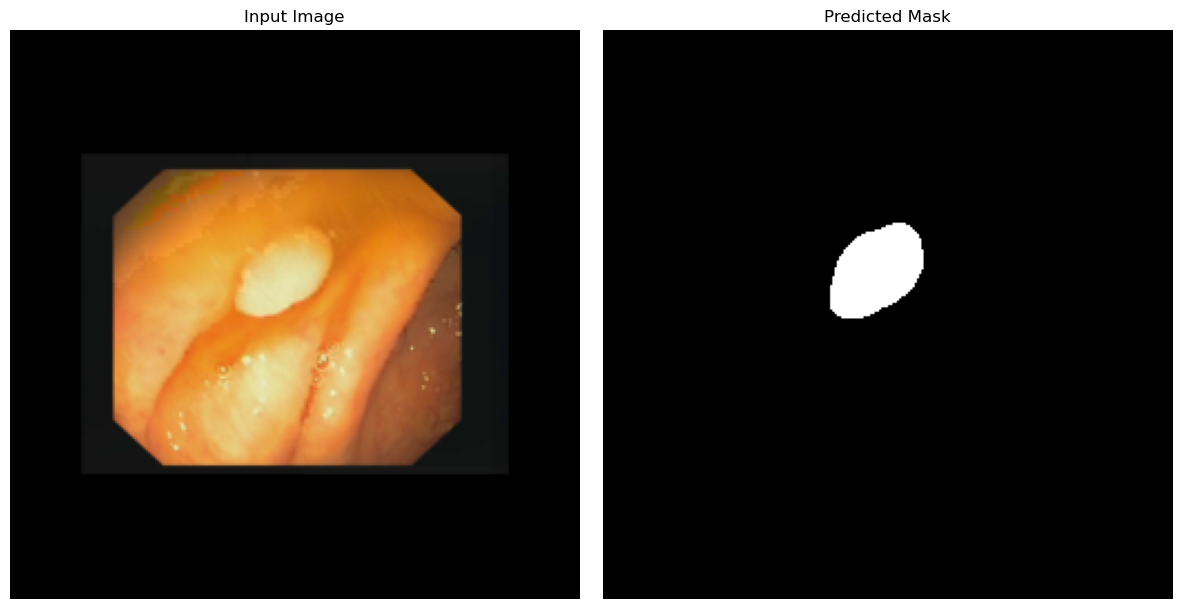

In [11]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

model =TransUNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load('best_enhanced_model.pth'))
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  
    return image

image_path = "CVC-ClinicDB_168.png"
image = preprocess_image(image_path)

with torch.no_grad():
    pred = model(image)
    pred_mask = (torch.sigmoid(pred) > 0.5) 


input_image = image.squeeze().permute(1, 2, 0).cpu().numpy()
input_image = (input_image * 0.5 + 0.5) * 255  
input_image = input_image.astype(np.uint8)

pred_mask = pred_mask.squeeze().cpu().numpy()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


(-0.5, 255.5, 255.5, -0.5)

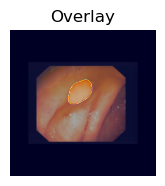

In [13]:
plt.subplot(1, 3, 3)
plt.imshow(input_image)
plt.imshow(pred_mask, alpha=0.3, cmap='jet') 
plt.title("Overlay")
plt.axis('off')

# Model evaluation

In [6]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import os
import random


def evaluate_model(model, test_loader):
    """Evaluate model on test dataset"""
    model.eval()
    total_dice = 0
    total_iou = 0
    total_acc = 0
    count = 0
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating"):
            images = images.to(config['DEVICE'])
            masks = masks.to(config['DEVICE'])
            
            outputs = model(images)
            dice, iou, acc = calculate_metrics(outputs, masks)
            
            total_dice += dice
            total_iou += iou
            total_acc += acc
            count += 1
    
    avg_dice = total_dice / count
    avg_iou = total_iou / count
    avg_acc = total_acc / count
    
    print(f"\n Evaluation Results:")
    print(f"Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Accuracy: {avg_acc:.4f}")
    
    return avg_dice, avg_iou, avg_acc



# Visualizations

In [44]:
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    plt.figure(figsize=(15, 5*num_samples))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.unsqueeze(0).to(config['DEVICE'])
        
        with torch.no_grad():
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred = (pred > 0.5).astype(np.float32)
        
        image = image.squeeze().permute(1, 2, 0).cpu().numpy()
        image = (image - image.min()) / (image.max() - image.min())  
        mask = mask.squeeze().cpu().numpy()
        
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions_visualization.png')
    plt.show()

In [46]:
def main_pipeline():
    
    print(" Starting Enhanced TransUNet Pipeline ⚡")
    
    model = TransUNet(in_channels=3, out_channels=1)
    model.load_state_dict(torch.load('best_enhanced_model.pth'))
    model = model.to(config['DEVICE'])
    model.eval()
    
    print("\n Evaluating on Test Set...")
    test_dataset = SpeedDataset(config['BASE_DIR'], 'test')
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['BATCH_SIZE'],
        shuffle=False
    )
    
    avg_dice, avg_iou, avg_acc = evaluate_model(model, test_loader)
    print(f"\nFinal Test Metrics:")
    print(f"Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f} | Accuracy: {avg_acc:.4f}")
    
    print("\nVisualizing Predictions...")
    visualize_predictions_with_overlay(model, test_dataset, num_samples=3)

In [12]:
def visualize_predictions_with_overlay(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    plt.figure(figsize=(18, 6*num_samples))
    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(config['DEVICE'])
        
        with torch.no_grad():
            pred = model(image_tensor)
            pred_mask = (torch.sigmoid(pred) > 0.5).squeeze().cpu().numpy()
        
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        true_mask_np = true_mask.squeeze().cpu().numpy()
        
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(image_np)
        plt.title(f"Sample {i+1}\nInput Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        
        plt.subplot(num_samples, 4, i*4+4)
        plt.imshow(image_np)
        plt.imshow(pred_mask, alpha=0.3, cmap='jet')
        plt.title("Overlay")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('test_predictions_with_overlay.png', bbox_inches='tight', dpi=300)
    print("Saved visualization as 'test_predictions_with_overlay.png'")
    plt.show()


⚡ Starting Enhanced TransUNet Pipeline ⚡


C:\Users\User\AppData\Local\Temp\ipykernel_10224\1078465987.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_enhanced_model.pth')


🔍 Evaluating on Test Set...
Using 75 samples for test


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Evaluation Results:
Dice: 0.8559 | IoU: 0.7801 | Accuracy: 0.9916

📊 Final Test Metrics:
Dice: 0.8559 | IoU: 0.7801 | Accuracy: 0.9916

🎨 Visualizing Predictions...
✅ Saved visualization as 'test_predictions_with_overlay.png'


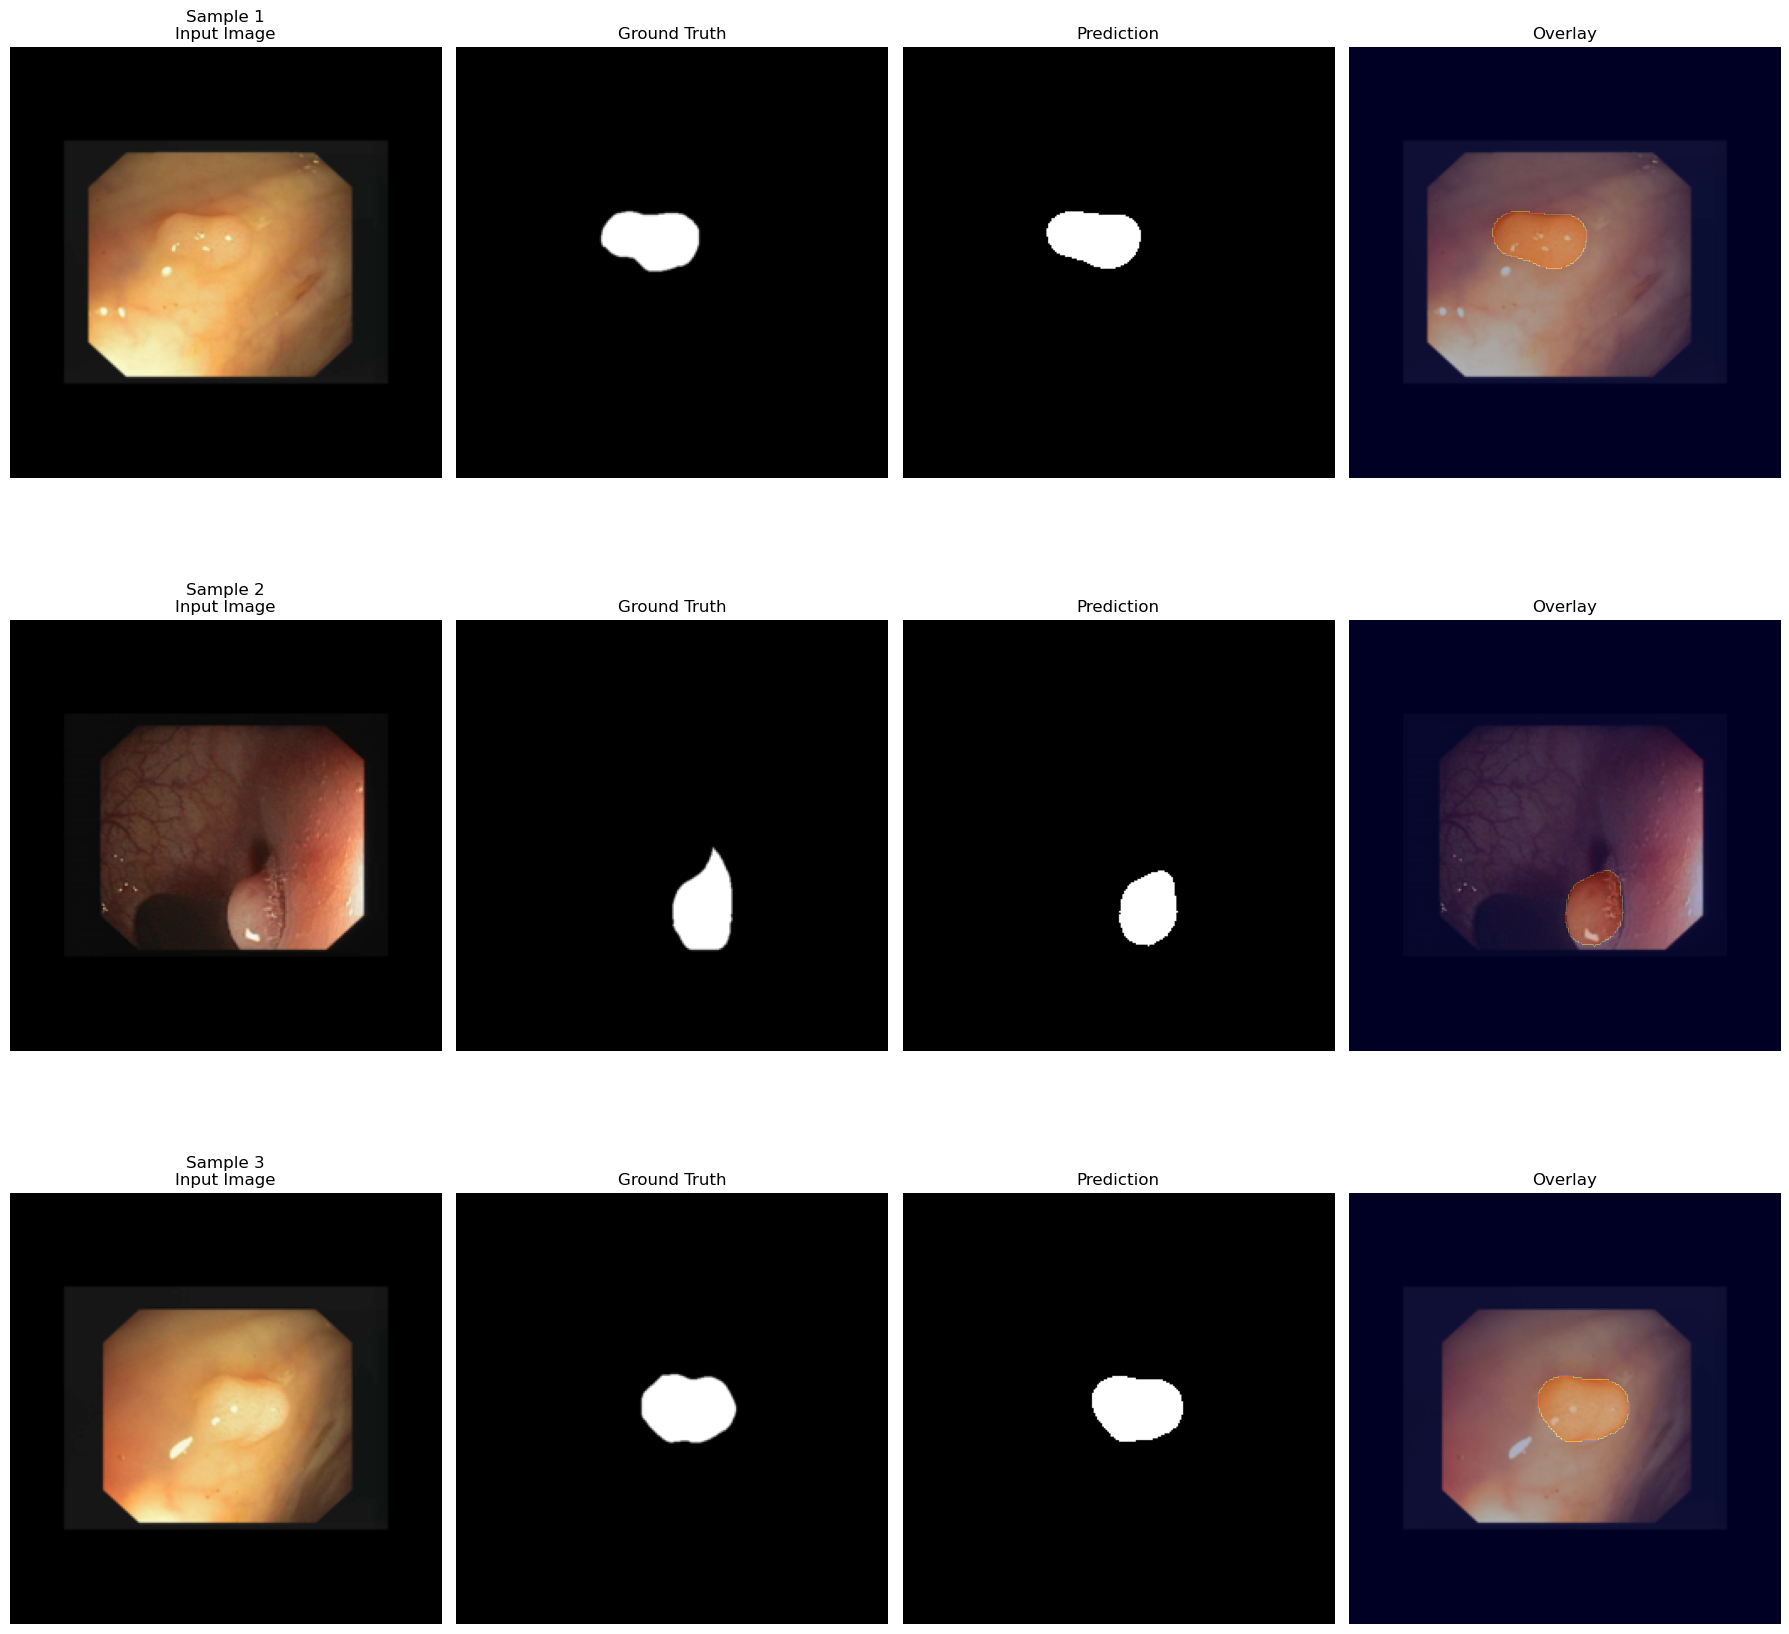

In [21]:
if __name__ == "__main__":
    main_pipeline()